# Preliminary Analysis
** In this section, prelminary analysis against the extrated dataset is going to take place including distribution analysis in different dimensions and contents analysis of the orginal data source** 

In [1]:
# import all necessary packages
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pickle
import pprint
import re
import requests
import urllib, urllib2
from collections import defaultdict
from __future__ import division
from itertools import count
import pandas as pd
import random as rand
import datetime
import itertools
import Levenshtein
import difflib
# IPython specifics
%matplotlib inline

In [2]:
#load the data file
data_path =os.getcwd()+"\\merged_data.pkl"
print data_path

with open(data_path, 'rb') as handle:
    coms_df= pickle.load(handle)

D:\1st Semester Master\Social Graphs and interaction\Project\merged_data.pkl


In [3]:
print "There are in total {} companies loaded into the project".format(len(coms_df.keys()))
print coms_df['General Motors'].keys()

There are in total 56871 companies loaded into the project
['wb_api_url', 'links', 'founded', 'name_url_quoted', 'logo', 'subsid', 'location_city', 'wiki_url', 'wiki_name', 'location', 'homepage', 'is_company', 'wiki_raw', 'parent', 'num_employees', 'wiki_api_url', 'location_geopy', 'wb_api_search_url', 'defunct', 'name', 'countries', 'type', 'industry', 'key_people', 'location_country', 'products', 'all_links', 'location_gps', 'wiki_page_id']


### General Histogram Distribution Analysis in accordance with Found and Defunct year 

In [32]:
com_founded_years=list()
com_defounded_years=list()
acient=0
for com, com_detail in coms_df.iteritems():
    if com_detail['founded']: 
        found_year=int(com_detail['founded'].year)
        if found_year>=1800 and found_year<=int(datetime.date.today().year):
            com_founded_years.append(int(found_year)) #put com founded after 1800 in the list
        elif found_year<1800: 
            acient=acient+1 #count of com eariler than 1800
    if com_detail['defunct']:
        defound_year=int(com_detail['defunct'].year)
        if defound_year>=1800 and defound_year<=int(datetime.date.today().year):
            com_defounded_years.append(int(defound_year))  #put com defunct after 1800 in the list

In [33]:
#compute defunct rate
com_founded_dict= dict()
com_founded_cum=dict()
com_founded_count=Counter(com_founded_years)

for key in sorted(com_founded_count.iterkeys()):
    com_founded_dict[key]= com_founded_count[key]
    
    acient=acient+com_founded_count[key]
    com_founded_cum[key]= acient

defunt_cum=0
com_defounded_dict= dict()

com_defounded_count=Counter(com_defounded_years)
for key in sorted(com_defounded_count.iterkeys()):
    com_defounded_dict[key]= com_defounded_count[key]
    
    defunt_cum=defunt_cum+com_defounded_count[key]
    com_founded_cum[key]=com_founded_cum[key]-defunt_cum
    
#patching defunct that year to 0 if no defunct in that year
years_no_defunct=set(com_defounded_dict.keys()).symmetric_difference(com_founded_dict.keys())
for year_no_defunct in years_no_defunct:
    com_defounded_dict[year_no_defunct]=0
    
defunct_rates=list()
for cum, defunct in zip(com_founded_cum.values(),com_defounded_dict.values()):
    defunct_rates.append((defunct/cum)*100)

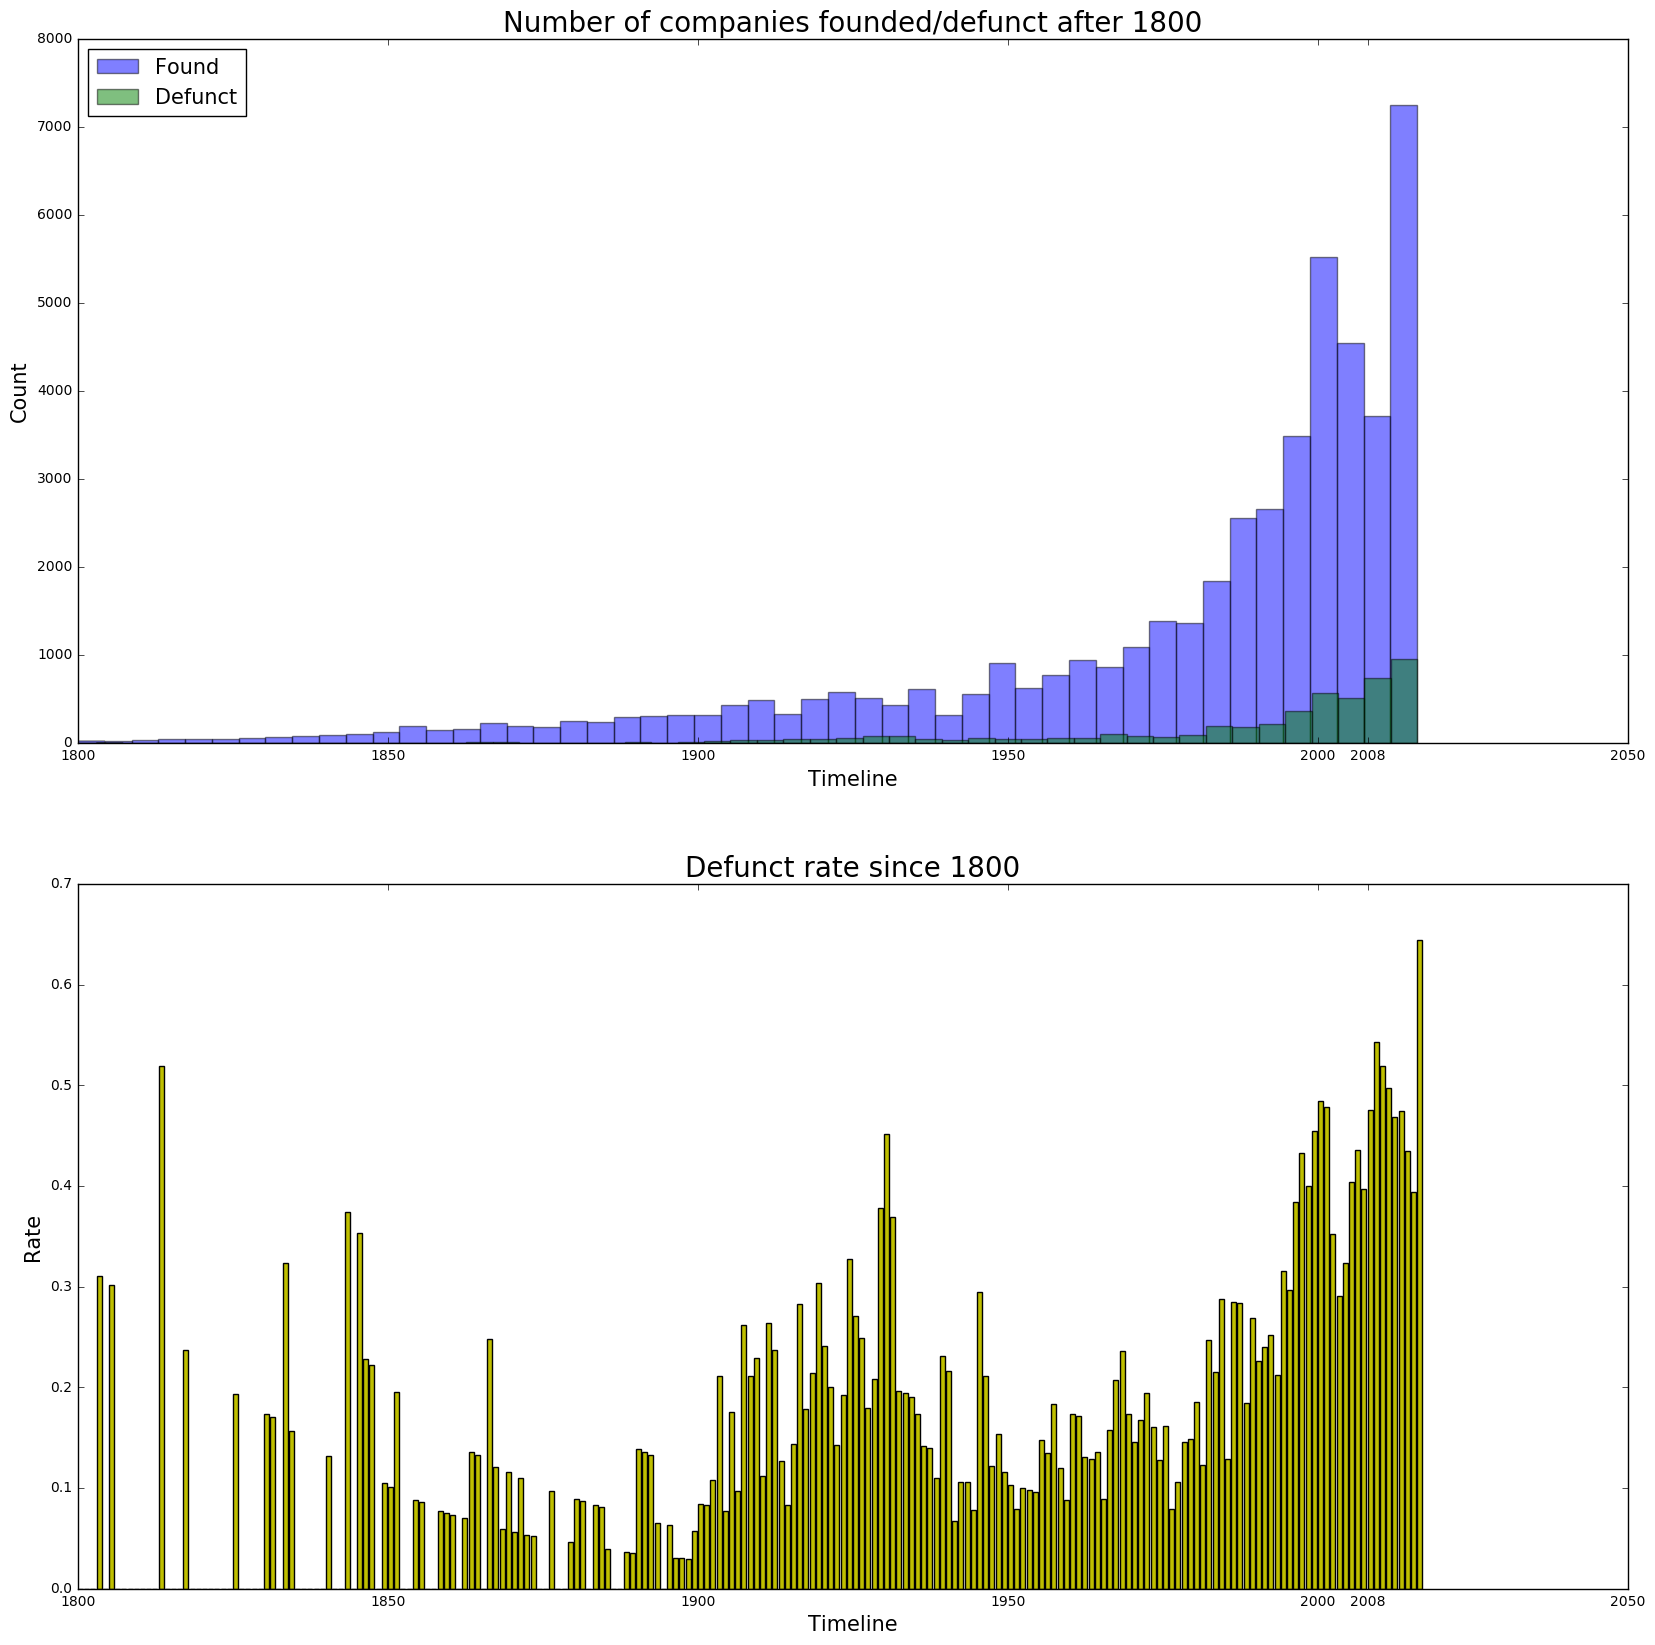

In [34]:
#plot histogram
fig = plt.figure(num=None, figsize=(20, 20), dpi=1200)
ax = fig.add_subplot(211)
count, bins, ignored = ax.hist(com_founded_years, bins=50,alpha=0.5, range=(min(com_founded_years), max(com_founded_years)),label="Found")
count, bins, ignored = ax.hist(com_defounded_years, bins=50,alpha=0.5, range=(min(com_defounded_years), max(com_defounded_years)),label="Defunct")

ax.legend(loc=2,fontsize=15)
ax.set_title("Number of companies founded/defunct after 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=15)
ax.set_ylabel('Count',fontsize=15)
plt.xticks(list(plt.xticks()[0]) + [2008]) #add special tick for 2008, possible financial crisis influence

ax = fig.add_subplot(212)
ax.bar(com_founded_dict.keys(),defunct_rates,color='y')
ax.set_title("Defunct rate since 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=15)
ax.set_ylabel('Rate',fontsize=15)


plt.xticks(list(plt.xticks()[0]) + [2008]) #add special tick for 2008, possible financial crisis influence
plt.show()

+ ** The histogram above shows the found and defunct of companies after 1800. The timeframe is set to 1800-2016 period (from early industrial revolution) as it is considered to be more morden society and the anaylsis is in result more connvincing. **

+ ** Generally, the amount of establishment increases gradually along the time. However in 2008, the number of founded company is significantly dropped. Possible reason would be partial side effect of the well-known Global Fiancial Crisis. **

+ ** The company defunct distribution has same tendency as company establishment. the amount generally increases along the time **

### Distribution of Company in accordance with Found year in different industries

In [42]:
#get general industry from the list of company
indust_years_dict=defaultdict(list)
indust_dfun_years_dict=defaultdict(list)
for com, com_detail in coms_df.iteritems():
    if com_detail['industry'] and com_detail['industry'][0] is not None:
        com_indus=",".join([ind.lower() for ind in com_detail['industry']]).split(",")[0]
        if com_detail['founded'] and com_detail['founded'].year>=1800 and com_detail['founded'].year<=datetime.date.today().year:
            
            indust_years_dict[com_indus].append(com_detail['founded'].year)
        
        if com_detail['defunct'] and com_detail['defunct'].year>=1800 and com_detail['defunct'].year<=datetime.date.today().year:

            indust_dfun_years_dict[com_indus].append(com_detail['defunct'].year)
            

# similairity check and deduplication using Levenshtein
threshold=0.6
for indus_1, indus_2 in itertools.combinations(indust_years_dict.keys(), 2):
    ratio=Levenshtein.ratio(indus_1,indus_2)
    if ratio>=threshold and indus_1 in indus_2:
        #print '%f\t%s\t\t could be \t\t%s' % (ratio, indus_1, indus_2)
        indust_years_dict[indus_1].extend(indust_years_dict[indus_2])
        del indust_years_dict[indus_2]
        indust_dfun_years_dict[indus_1].extend(indust_dfun_years_dict[indus_2])
        del indust_dfun_years_dict[indus_2]

In [35]:
indust_len_dict=dict()
for indust, years in indust_years_dict.iteritems():
    indust_len_dict[indust]=len(years)
    
i=5
print "Top {} (industry, quantity of company) {} with most amount of founed companies".format(i, Counter(indust_len_dict).most_common(i))

Top 5 (industry, quantity of company) [(u'retail', 1625), (u'financial', 1588), (u'communications', 1068), (u'automotive', 1030), (u'software', 988)] with most amount of founed companies


In [36]:
indust_dfun_len_dict=dict()
for indust, years in indust_dfun_years_dict.iteritems():
    indust_dfun_len_dict[indust]=len(years)
    
i=5
print "Top {} (industry, quantity of company) {} with most amoun of defunct companies".format(i, Counter(indust_dfun_len_dict).most_common(i))

Top 5 (industry, quantity of company) [(u'retail', 359), (u'automotive', 238), (u'aerospace', 161), (u'manufacturing', 136), (u'financial', 133)] with most amoun of defunct companies


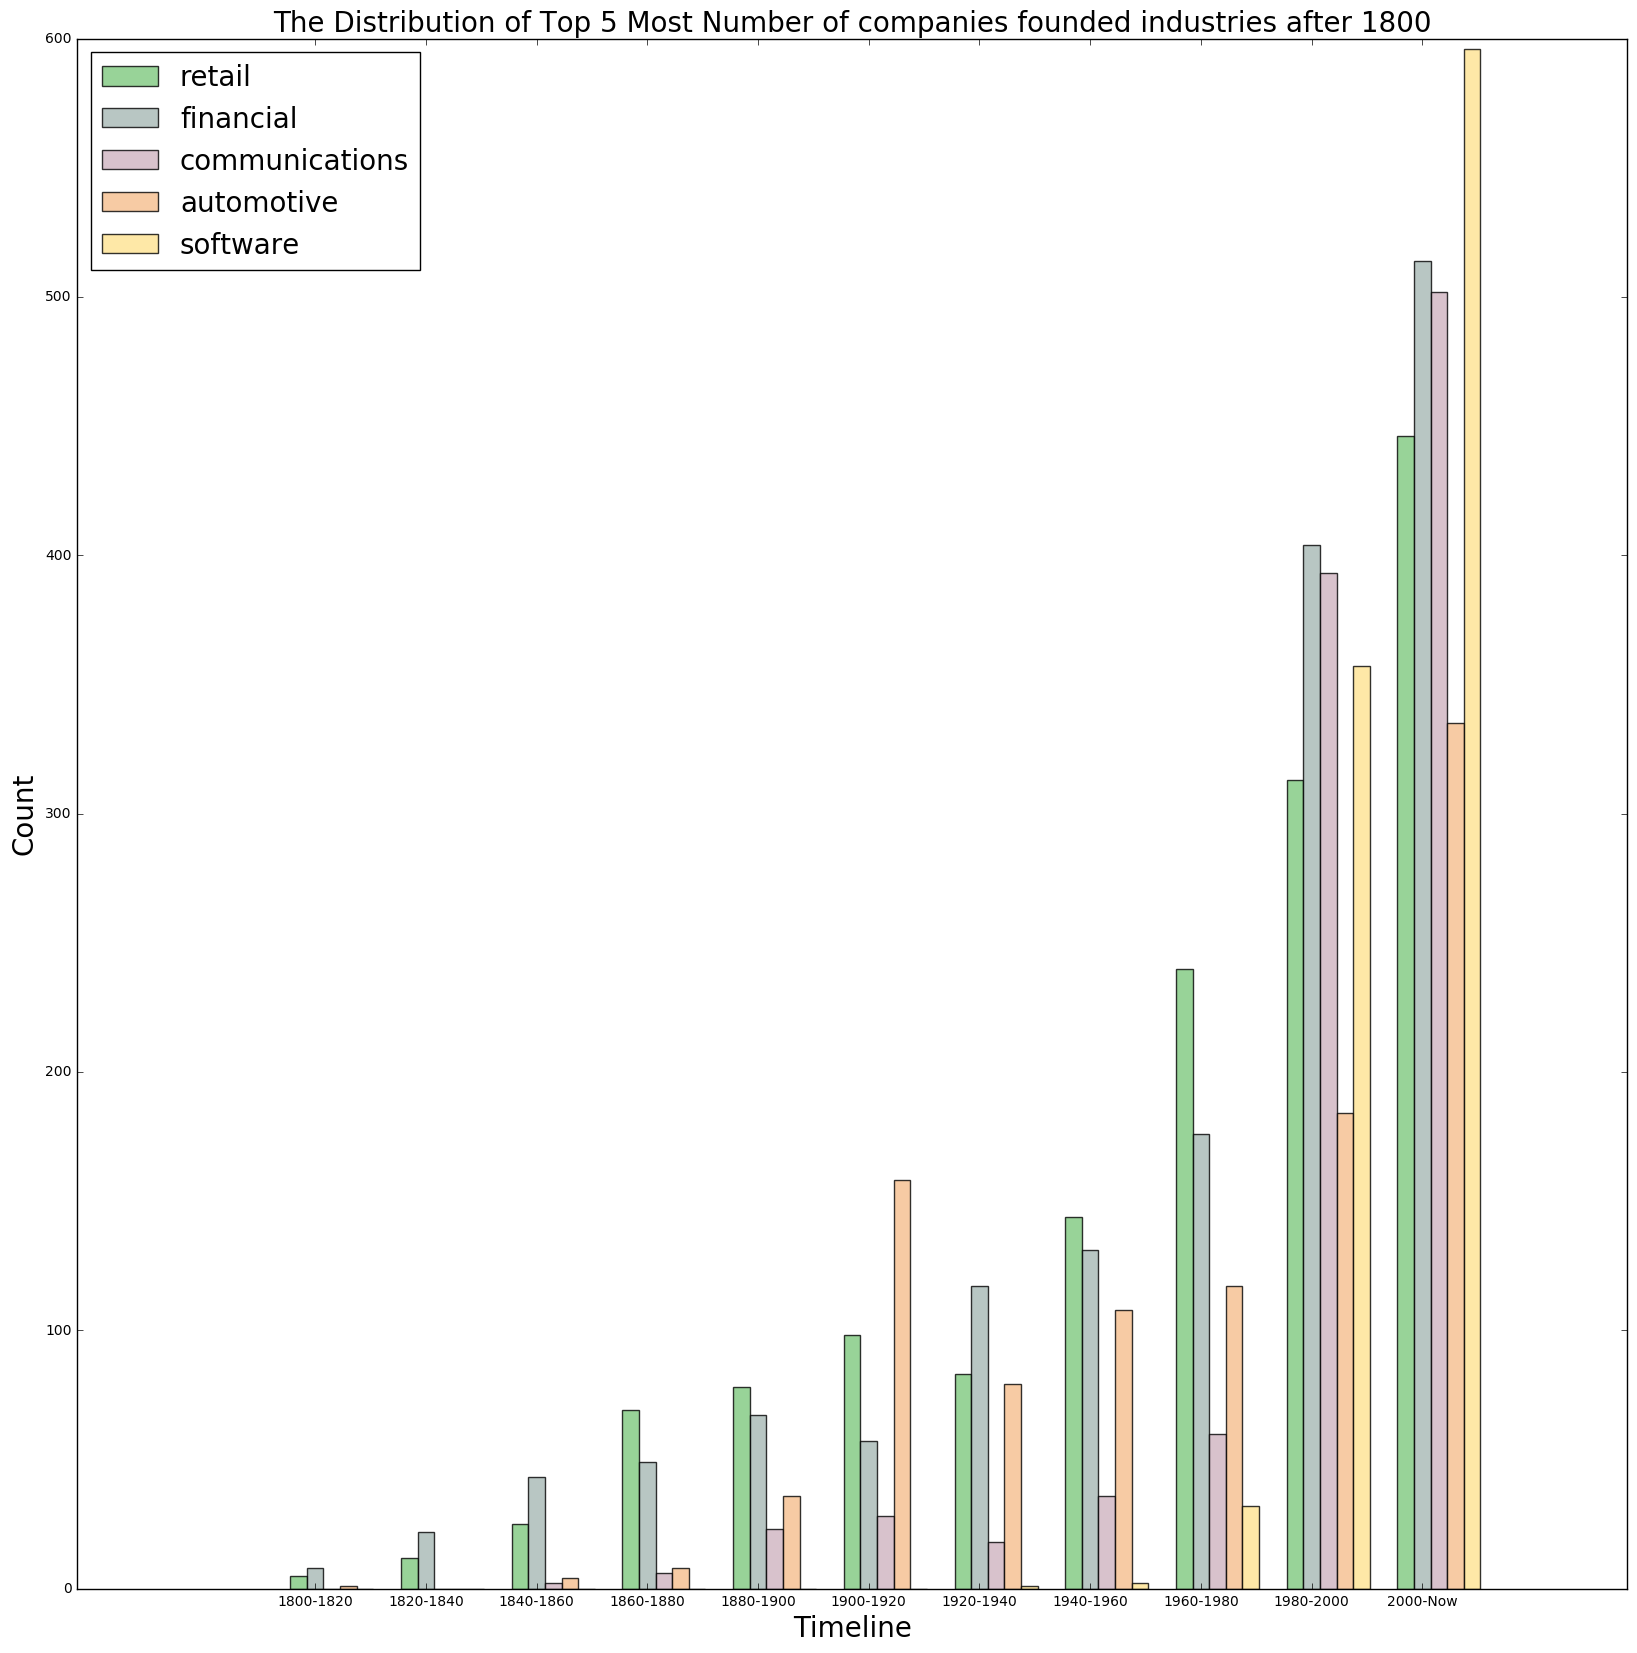

In [39]:
#plot histogram
scales=11 #total timeframes
index = np.arange(scales) #time frames index
bar_width = 0.15 #bar width
opacity = 0.8 #opacity
scale=20 #time frame width


fig = plt.figure(num=None, figsize=(20, 20), dpi=1200)
ax = fig.add_subplot(111)

for ind_index, indust_tuple in enumerate(Counter(indust_len_dict).most_common(i)):
    indust_year_list=indust_years_dict[indust_tuple[0]]
    indust_scale_list=list()
    for n_group in index:
        low_border=1800+n_group*scale
        high_border=1800+(n_group+1)*scale
        year_per_scale=len([year for year in indust_year_list if year >= low_border and year<high_border])
        indust_scale_list.append(year_per_scale)
        
    rects1 = plt.bar(index+bar_width*ind_index, tuple(indust_scale_list), bar_width, align='center', color=plt.cm.Accent(float(ind_index) / scales), alpha=opacity, label=indust_tuple[0])
    
ax.legend(loc=2,fontsize=20)
ax.set_title("The Distribution of Top 5 Most Number of companies founded industries after 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
plt.xticks(index + bar_width, ('1800-1820', '1820-1840', '1840-1860', '1860-1880', '1880-1900','1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-Now'))
plt.show()

The plot has the distribution of established companies in several most common industries along the time. They respectively reflected the development of each industry and after some investigations, following observations have been made

+ ** Automobile industry remained silent and was suddenly boosted rapidly after 1900. Several historical events fecilitated the phenomenon. Prior to 1900, the automobile was really a novelty item, but in 1908, company such as Ford Motor Company created the Model T, which became the first car aggressively marketed to the average family. Commercialisation began **

+ ** Software industry starts to welcome a rapid increasin number of companies around 80s due to the extraoridinary development of computer. During the thrid industrial revolution (late 90s), more and more software or computer-related companies were founded. **
+ ** As same as software industry, the communication industry was also promptly developed after the invension of internet. Therefore, as the red bar in the plot shown, at the end of 20th centrey, a drasticall increment of the amount of founded companies within telecommunication industry has taken place **
+ ** The amount of company established in Retail and Finance industry generally comply to incremental tendency along the time. **

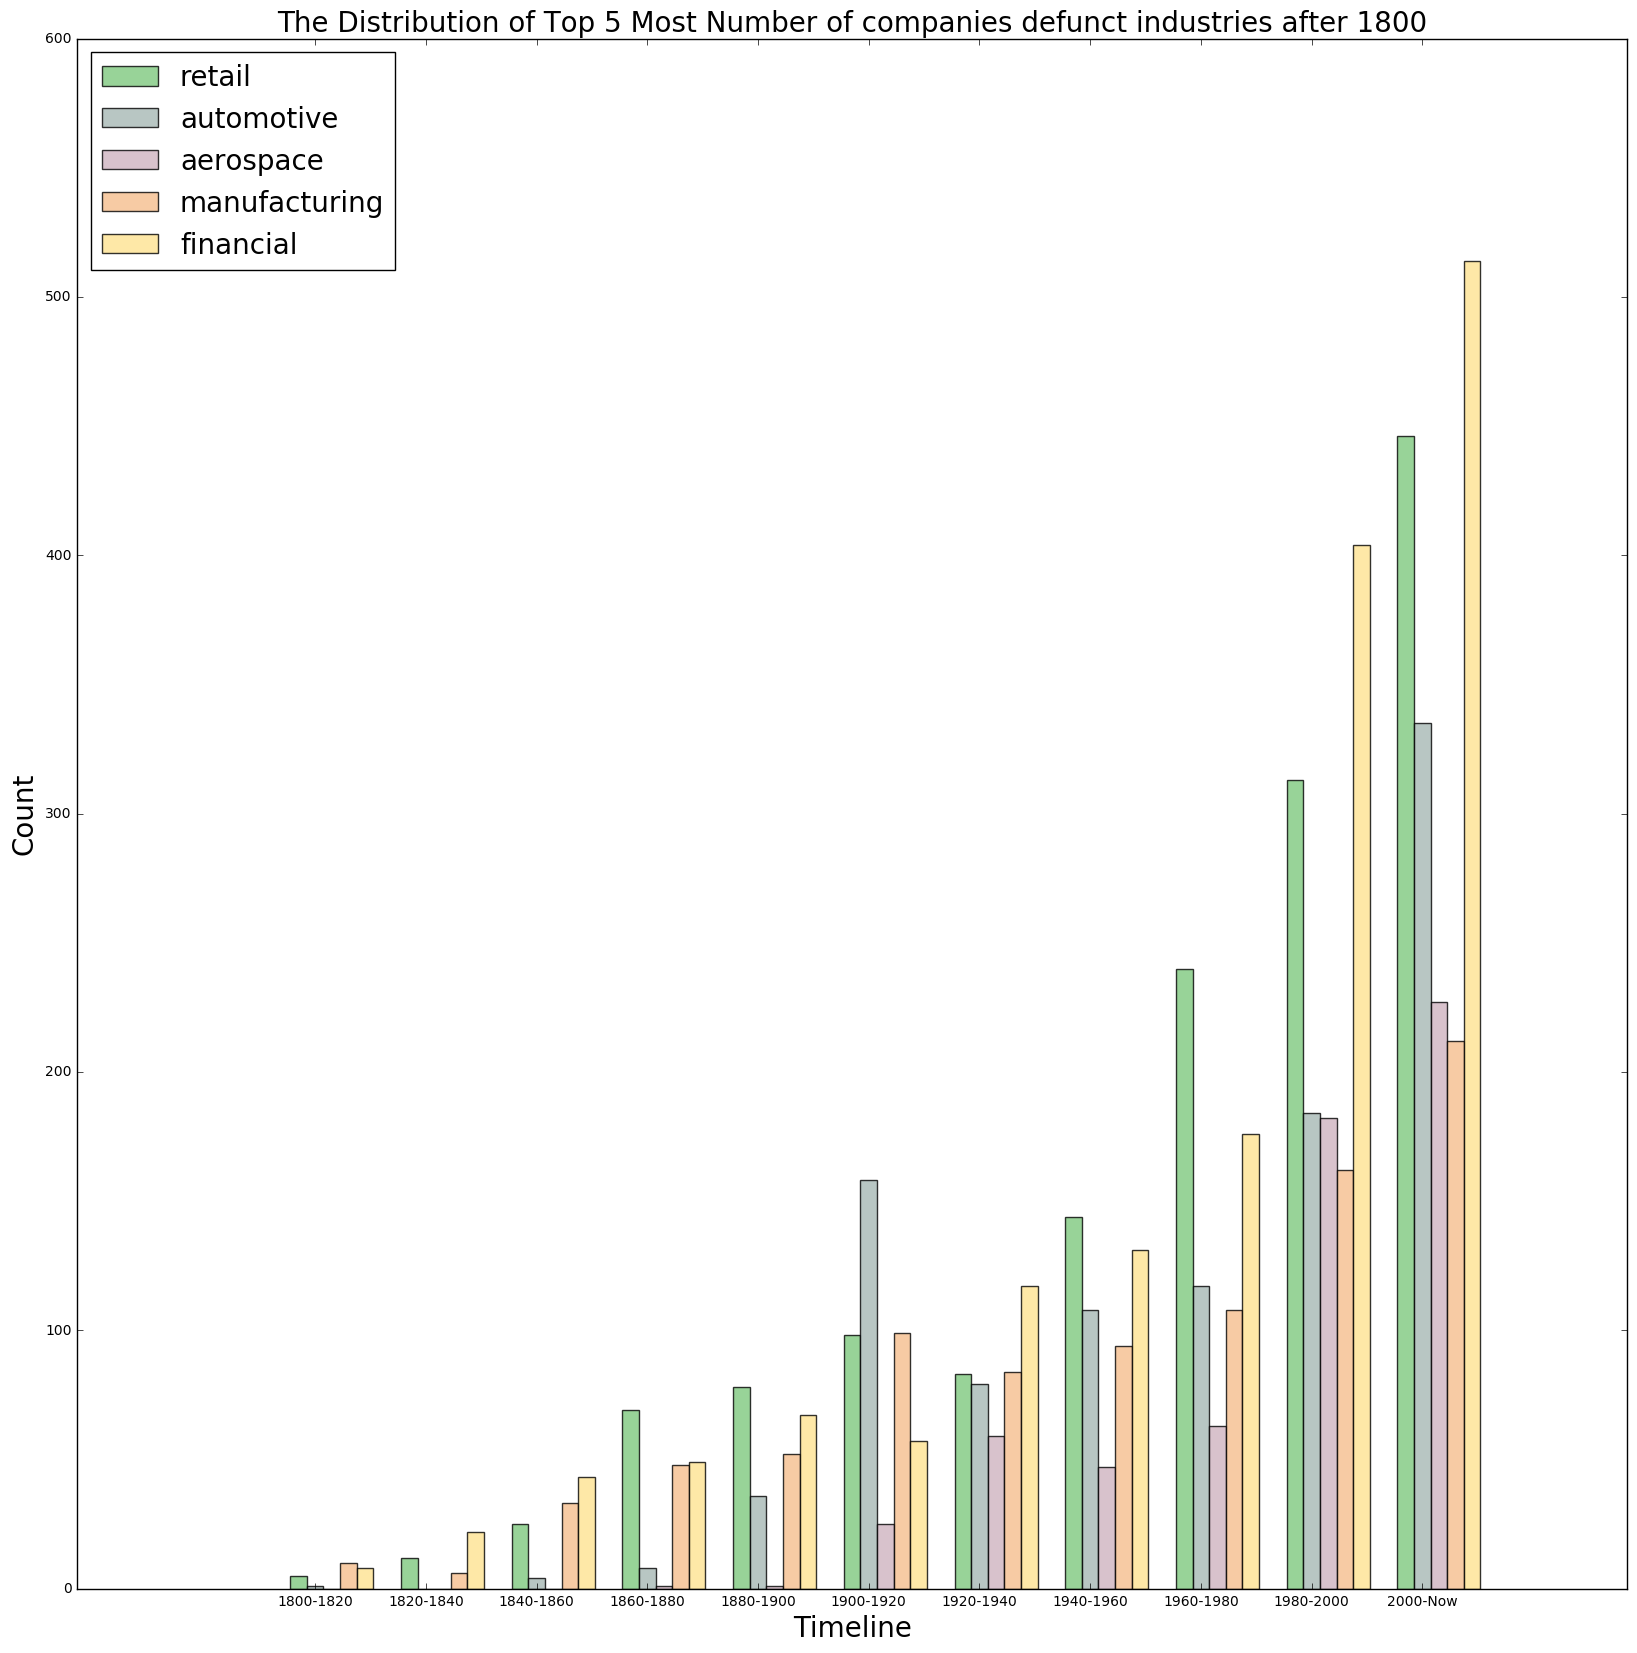

In [41]:
#plot histogram
scales=11 #total timeframes
index = np.arange(scales) #time frames index
bar_width = 0.15 #bar width
opacity = 0.8 #opacity
scale=20 #time frame width


fig = plt.figure(num=None, figsize=(20, 20), dpi=1200)
ax = fig.add_subplot(111)

for ind_index, indust_tuple in enumerate(Counter(indust_dfun_len_dict).most_common(i)):
    indust_year_list=indust_years_dict[indust_tuple[0]]
    indust_scale_list=list()
    for n_group in index:
        low_border=1800+n_group*scale
        high_border=1800+(n_group+1)*scale
        year_per_scale=len([year for year in indust_year_list if year >= low_border and year<high_border])
        indust_scale_list.append(year_per_scale)
        
    rects1 = plt.bar(index+bar_width*ind_index, tuple(indust_scale_list), bar_width, align='center', color=plt.cm.Accent(float(ind_index) / scales), alpha=opacity, label=indust_tuple[0])
    
ax.legend(loc=2,fontsize=20)
ax.set_title("The Distribution of Top 5 Most Number of companies defunct industries after 1800",fontsize=20)
ax.set_xlabel('Timeline',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
plt.xticks(index + bar_width, ('1800-1820', '1820-1840', '1840-1860', '1860-1880', '1880-1900','1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-Now'))
plt.show()

The plot has the distribution of defunct companies in several most common industries along the time. They respectively reflects the reduction of each industry and after some investigations, following observations have been made

+ **finance remain a stable rate/trend of increasing until 1980-2000. the amount of defunct company in finance area increases rapidly. until now, the amount of defunct is almost three times to 1960-1980 period **

+ ** As for automobile industry, while a increasing amount of companies established in 1900-1920, there are also many companies defunct in this period. One reason is that Car making at the start of the 20th century was like internet entrepreneurialism at the end of it: plenty jumped into the pool, but only the fittest survived in a market that many didn’t understand. Failure to spot the competition and poor management all contributed to the demise of car makers **

+ ** Same story also happens for aerospace industry. the development of aerospace industry is a byproduct of cold war as an extension project of military industry including missle, aircraft and so on. At the beginning of 80s, the Space Shuttle Columbia launched, the start of regular manned access to orbital space. A sustained human presence in orbital space started with "Mir" in 1986 and is continued by the "International Space Station".Space commercialization and space tourism are more recent focuses in aerospace. However, due to the unmatrue technologies, industrial uncertainty and high cost in R&D, many companies failed to keep up with the speed thus ended to be defunct. Therefore, there is a steep climbing from 1960-1980 to 1980-2000**

+ ** The amount of company defunct in Retail and manufacturing industry generally comply to incremental tendency along the time. **